# Buffer Stock Model

# Setup

In [17]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt


# load the BufferStockModel module
from BufferStockModel import BufferStockModelClass

# for timing
from consav.misc import elapsed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
nb.set_num_threads(1) # use a single thread for clarity

# First Example

In [19]:
model_negm = BufferStockModelClass(name='baseline',par={'solmethod':'egm'})

In [20]:
model_negm.solve()

 t = 59 solved in 2.4 secs
 t = 59 solved in 0.0 secs
 t = 59 solved in 0.0 secs
 t = 58 solved in 4.5 secs (w: 3.0 secs)
 t = 58 solved in 0.5 secs (w: 0.5 secs)
 t = 58 solved in 0.5 secs (w: 0.5 secs)
 t = 57 solved in 0.5 secs (w: 0.5 secs)
 t = 57 solved in 0.5 secs (w: 0.5 secs)
 t = 57 solved in 0.5 secs (w: 0.5 secs)
 t = 56 solved in 0.5 secs (w: 0.5 secs)
 t = 56 solved in 0.5 secs (w: 0.5 secs)
 t = 56 solved in 0.5 secs (w: 0.5 secs)
 t = 55 solved in 0.5 secs (w: 0.5 secs)
 t = 55 solved in 0.5 secs (w: 0.5 secs)
 t = 55 solved in 0.5 secs (w: 0.5 secs)
 t = 54 solved in 0.5 secs (w: 0.5 secs)
 t = 54 solved in 0.5 secs (w: 0.5 secs)
 t = 54 solved in 0.6 secs (w: 0.6 secs)
 t = 53 solved in 0.5 secs (w: 0.5 secs)
 t = 53 solved in 0.5 secs (w: 0.5 secs)
 t = 53 solved in 0.5 secs (w: 0.5 secs)
 t = 52 solved in 0.5 secs (w: 0.5 secs)
 t = 52 solved in 0.5 secs (w: 0.5 secs)
 t = 52 solved in 0.5 secs (w: 0.5 secs)
 t = 51 solved in 0.5 secs (w: 0.5 secs)
 t = 51 solved in

In [21]:
model_negm.simulate()

model simulated in 1.8 secs


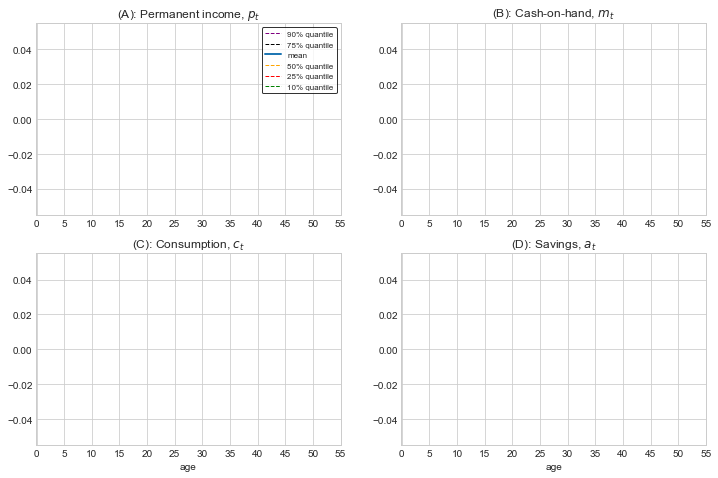

In [22]:
model_negm.lifecycle()

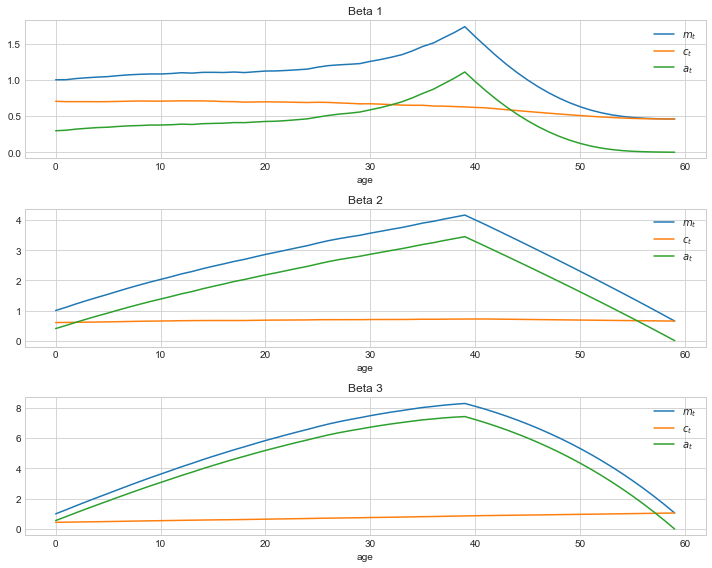

In [23]:
# a. unpack
par = model_negm.par
sim = model_negm.sim

# b. figure
fig, axs = plt.subplots(len(par.Betas), 1, figsize=(10, 8))

simvarlist = [('m','$m_t$'),
              ('c','$c_t$'),
              ('a','$a_t$')]

age = np.arange(par.T)

for b in range(len(par.Betas)):  # loop over beta dimension
    ax = axs[b]  # specify the current subplot

    for simvar, simvarlatex in simvarlist:
        # get simulation data
        simdata = getattr(sim, simvar)

        # calculate mean over individual dimension for each beta
        mean_data = np.mean(simdata[:, b, :], axis=1)

        # plot mean data
        ax.plot(age, mean_data, label=simvarlatex)

    ax.grid(True)
    ax.set_xlabel('age')
    ax.set_title(f'Beta {b+1}')
    ax.legend()

# adjust layout for better visualization
plt.tight_layout()
plt.show()

In [24]:
model_negm.simulate_rand()

model simulated in 1.7 secs


Text(0.5, 0, 'age')

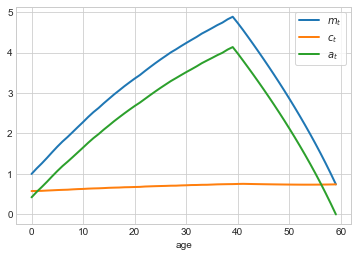

In [25]:
# a. unpack
par = model_negm.par
sim = model_negm.sim

# b. figure
fig = plt.figure()

simvarlist = [('m','$m_t$'),
              ('c','$c_t$'),
              ('a','$a_t$')]

age = np.arange(par.T)
ax = fig.add_subplot(1,1,1)

for simvar,simvarlatex in simvarlist:

    simdata = getattr(sim,simvar+'_rand')
    ax.plot(age,np.mean(simdata,axis=1),lw=2,label=simvarlatex)

ax.legend(frameon=True)
ax.grid(True)
ax.set_xlabel('age')

In [21]:
model_egm = BufferStockModelClass(name='baseline',par={'solmethod':'egm'})

In [22]:
model_egm.solve()

 t = 4 solved in 0.9 secs
 t = 4 solved in 0.0 secs
 t = 4 solved in 0.0 secs
 t = 3 solved in 4.6 secs (w: 3.2 secs)
 t = 3 solved in 0.5 secs (w: 0.5 secs)
 t = 3 solved in 0.5 secs (w: 0.5 secs)
 t = 2 solved in 0.5 secs (w: 0.5 secs)
 t = 2 solved in 0.5 secs (w: 0.5 secs)
 t = 2 solved in 0.5 secs (w: 0.5 secs)
 t = 1 solved in 0.5 secs (w: 0.5 secs)
 t = 1 solved in 0.5 secs (w: 0.5 secs)
 t = 1 solved in 0.5 secs (w: 0.5 secs)
 t = 0 solved in 0.5 secs (w: 0.5 secs)
 t = 0 solved in 0.5 secs (w: 0.5 secs)
 t = 0 solved in 0.5 secs (w: 0.5 secs)


The code is easiest to understand for **nvfi** and **do_simple_w = True**. The cell below solves the model using these settings. Go through the code this  cell is calling to understand the interface.

In [23]:
model_egm.simulate()

model simulated in 1.5 secs


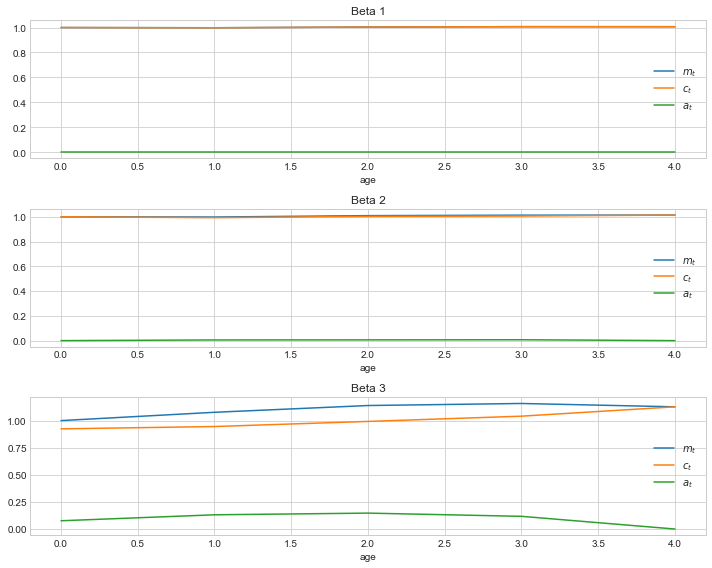

In [24]:
# a. unpack
par = model_egm.par
sim = model_egm.sim

# b. figure
fig, axs = plt.subplots(len(par.Betas), 1, figsize=(10, 8))

simvarlist = [('m','$m_t$'),
              ('c','$c_t$'),
              ('a','$a_t$')]

age = np.arange(par.T)

for b in range(len(par.Betas)):  # loop over beta dimension
    ax = axs[b]  # specify the current subplot

    for simvar, simvarlatex in simvarlist:
        # get simulation data
        simdata = getattr(sim, simvar)

        # calculate mean over individual dimension for each beta
        mean_data = np.mean(simdata[:, b, :], axis=1)

        # plot mean data
        ax.plot(age, mean_data, label=simvarlatex)

    ax.grid(True)
    ax.set_xlabel('age')
    ax.set_title(f'Beta {b+1}')
    ax.legend()

# adjust layout for better visualization
plt.tight_layout()
plt.show()

In [16]:
model = BufferStockModelClass(name='baseline',par={'solmethod':'vfi'})

In [18]:
model.solve()

 t = 4 solved in 0.9 secs
 t = 4 solved in 0.0 secs
 t = 4 solved in 0.0 secs
 t = 3 solved in 35.2 secs (w: 0.0 secs)
 t = 3 solved in 30.9 secs (w: 0.0 secs)
 t = 3 solved in 31.1 secs (w: 0.0 secs)
 t = 2 solved in 31.0 secs (w: 0.0 secs)
 t = 2 solved in 31.0 secs (w: 0.0 secs)
 t = 2 solved in 32.4 secs (w: 0.0 secs)
 t = 1 solved in 31.9 secs (w: 0.0 secs)
 t = 1 solved in 31.8 secs (w: 0.0 secs)
 t = 1 solved in 32.1 secs (w: 0.0 secs)
 t = 0 solved in 31.8 secs (w: 0.0 secs)
 t = 0 solved in 31.8 secs (w: 0.0 secs)
 t = 0 solved in 31.3 secs (w: 0.0 secs)


In [23]:
model.sol.c[0,1,:,:]

array([[9.95975344e-07, 5.58473053e-04, 2.07132795e-03, ...,
        4.12598957e+00, 4.16704267e+00, 4.20084574e+00],
       [9.95975344e-07, 5.31767517e-03, 1.08664389e-02, ...,
        4.13829432e+00, 4.17551589e+00, 4.21202578e+00],
       [9.95975344e-07, 1.00942512e-02, 2.19686766e-02, ...,
        4.15008226e+00, 4.18539474e+00, 4.22252912e+00],
       ...,
       [9.95975344e-07, 1.76150957e-02, 3.52460592e-02, ...,
        1.12670501e+01, 1.12964800e+01, 1.13355633e+01],
       [9.95975344e-07, 1.76150957e-02, 3.52460592e-02, ...,
        1.13475445e+01, 1.13747552e+01, 1.14132237e+01],
       [9.95975344e-07, 1.76150957e-02, 3.52460592e-02, ...,
        1.14326267e+01, 1.14645250e+01, 1.14986450e+01]])

In [24]:
model.simulate()

model simulated in 0.0 secs


In [7]:
model_egm.par.Betas

array([0.98, 0.98, 0.98])

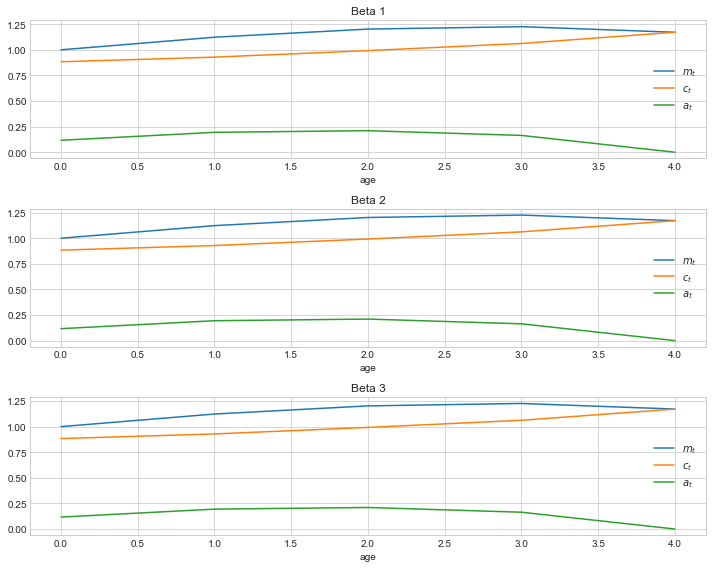

In [28]:
# a. unpack
par = model.par
sim = model.sim

# b. figure
fig, axs = plt.subplots(len(par.Betas), 1, figsize=(10, 8))

simvarlist = [('m','$m_t$'),
              ('c','$c_t$'),
              ('a','$a_t$')]

age = np.arange(par.T)

for b in range(len(par.Betas)):  # loop over beta dimension
    ax = axs[b]  # specify the current subplot

    for simvar, simvarlatex in simvarlist:
        # get simulation data
        simdata = getattr(sim, simvar)

        # calculate mean over individual dimension for each beta
        mean_data = np.mean(simdata[:, b, :], axis=1)

        # plot mean data
        ax.plot(age, mean_data, label=simvarlatex)

    ax.grid(True)
    ax.set_xlabel('age')
    ax.set_title(f'Beta {b+1}')
    ax.legend()

# adjust layout for better visualization
plt.tight_layout()
plt.show()

heterogenous

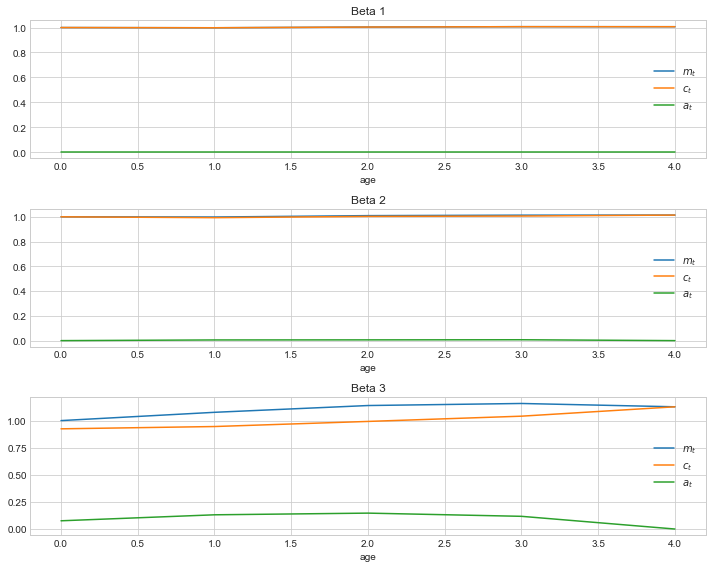

In [13]:
# a. unpack
par = model.par
sim = model.sim

# b. figure
fig, axs = plt.subplots(len(par.Betas), 1, figsize=(10, 8))

simvarlist = [('m','$m_t$'),
              ('c','$c_t$'),
              ('a','$a_t$')]

age = np.arange(par.T)

for b in range(len(par.Betas)):  # loop over beta dimension
    ax = axs[b]  # specify the current subplot

    for simvar, simvarlatex in simvarlist:
        # get simulation data
        simdata = getattr(sim, simvar)

        # calculate mean over individual dimension for each beta
        mean_data = np.mean(simdata[:, b, :], axis=1)

        # plot mean data
        ax.plot(age, mean_data, label=simvarlatex)

    ax.grid(True)
    ax.set_xlabel('age')
    ax.set_title(f'Beta {b+1}')
    ax.legend()

# adjust layout for better visualization
plt.tight_layout()
plt.show()

## Load/save

**Delete** the model:

In [4]:
del model

**Load** the model again:

In [5]:
model_loaded = BufferStockModelClass(name='baseline',load=True)

**Plot** the consumption function in period $t=0$:

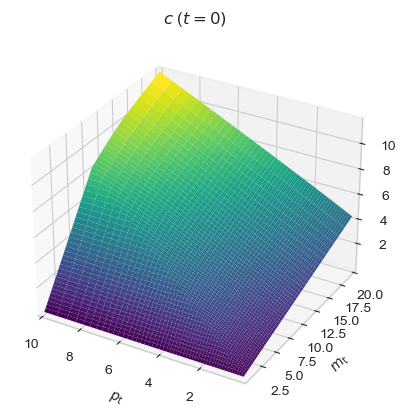

In [6]:
model_loaded.consumption_function(t=0)

**Copy** the model:

In [7]:
model_copy = model_loaded.copy() # name can be specified
print(model_copy.name)

baseline_copy


**Plot** the life-cycle profiles:

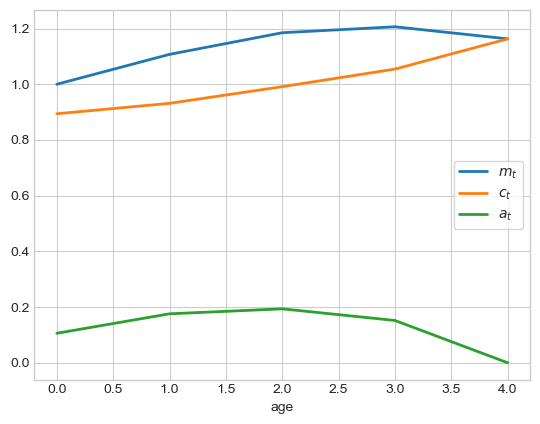

In [8]:
model_copy.lifecycle()

**Plot** an interactive version of the consumption function:

In [ ]:
model_loaded.consumption_function_interact()

# Timings

**Time** the various solution methods and show the importance of the optimized computation of $q_t(p_t,a_t)$ in EGM (i.e. setting `do_simple_w = False`).

In [ ]:
t0 = time.time()
model = BufferStockModelClass(name='')
print(f'time to setup: {elapsed(t0)}')

In [ ]:
for solmethod in ['nvfi','egm','vfi']:    
    for do_simple_w in [True,False]:
        
        if solmethod == 'vfi' and do_simple_w: continue # skip this
    
        print(f'{solmethod}',end='')        
        
        if not solmethod == 'vfi':
            print(f' (do_simple_w = {do_simple_w})')
        else:
            print('')
        
        # a. change solution method
        model.par.solmethod = solmethod
        model.par.do_simple_w = do_simple_w
        model.par.do_print = False
    
        # b. test run 
        t0 = time.time()
        model.solve()
        model.par.do_print = True
        print(f'time in test run: {elapsed(t0)}')

        # c. final run
        t0 = time.time()
        model.solve()
        print(f'time in final run: {elapsed(t0)} [checksum: {model.checksum():.8f}]')
        print('')
        

## Test Parallelization

In [ ]:
threads_list = [x for x in np.arange(1,nb.config.NUMBA_NUM_THREADS+1) if x in [1,4,8] or x%8 == 0]

In [ ]:
solmethod = 'egm'
for do_simple_w in [False,True]:
    
    print(f'{solmethod} (do_simple_w = {do_simple_w}) ')
    
    for threads in threads_list:

        nb.set_num_threads(threads)
        
        # a. change solution method
        model.par.solmethod = solmethod
        model.par.do_simple_w = do_simple_w
        model.par.do_print = False

        # b. run
        t0 = time.time()
        model.solve()
        print(f' time to solve with {threads:2d} threads: {elapsed(t0)} [checksum: {model.checksum():.8f}]')
    
    print('')


**Conclusion:** Numba is not always parallizing that well. And using too many threads can even be harmful.